In [118]:
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import matplotlib.patches as mpatches

# Read data and preprocess

In [195]:
bm=pd.read_csv('BM25Ranking_jun_v1.csv')
q=pd.read_csv('QueryLikelihoodRanking_jun.csv')
ti=pd.read_csv('TFIDFRanking_jun.csv')
bo=pd.read_csv('BooleanRanking_jun.csv')
bmp=pd.read_csv('BM25Ranking_PR_jun.csv')
qp=pd.read_csv('QueryLikelihoodRanking_PR_jun.csv')
tip=pd.read_csv('TFIDFRanking_PR_jun.csv')

In [196]:
def change_binary(data):
    non_rel=[]
    for x in data.relevance:
        if x>0:
            non_rel.append(1)
        else: 
            non_rel.append(0)
    data['b_relevance']=non_rel
    return data
q=change_binary(q)
bm=change_binary(bm)
ti=change_binary(ti)
bo=change_binary(bo)
bmp=change_binary(bmp)
qp=change_binary(qp)
tip=change_binary(tip)

In [186]:
frames = [bm,q,ti,bo,bmp,qp,tip]
comb = pd.concat(frames)

In [187]:
comb.relevance.value_counts()

0    148
1     45
2     17
Name: relevance, dtype: int64

In [188]:
cl_comb=comb.drop_duplicates()

In [189]:
cl_comb.relevance.value_counts()

0    71
1    23
2     7
Name: relevance, dtype: int64

In [190]:
len(cl_comb)

101

there are overall 101 links, where 71 zeros, 23 ones and 2 twos. 

71 non-relevant docs, 30 relevant docs.

# calculate metrics

In [191]:
def pr_curve(retrieved_list,num_pos):
    a=retrieved_list
    #recall= retrieved relevant/retrieved relevant+not retrieved relevant
    recall=[]
    #precision = retrieved relevant/total retrieved
    precision=[]
    #num_pos=sum(t)
    for i in range(1,len(a)):
        recall.append(sum(a[:i])/num_pos)
        precision.append(sum(a[:i])/i)
    a=plt.plot(recall,precision,'-')
    #plt.xlabel('recall')
    #plt.ylabel('precision')
    #plt.show()
    return a


In [192]:
pr_curve(bm.b_relevance,30),
pr_curve(q.b_relevance,30),
pr_curve(ti.b_relevance,30),
pr_curve(bo.b_relevance,30),
pr_curve(bmp.b_relevance,30),
pr_curve(qp.b_relevance,30),
pr_curve(tip.b_relevance,30),

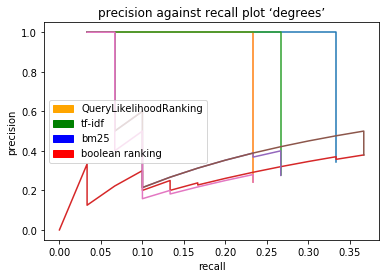

In [193]:
plt.show(b)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision against recall plot ‘degrees’')
green_patch = mpatches.Patch(color='green', label='tf-idf')
orange_patch = mpatches.Patch(color='orange', label='QueryLikelihoodRanking')
blue_patch = mpatches.Patch(color='blue', label='bm25')
red_patch = mpatches.Patch(color='red', label='boolean ranking')
plt.legend(handles=[orange_patch,green_patch,blue_patch,red_patch])



# recall, precision, F1

In [51]:

def f1_pr_rc(retrieved_list,num_pos):
    a=retrieved_list
    r=sum(a)/num_pos #recall
    p=sum(a)/len(a) #precision
    F1=2*r*p/(r+p)
    return r,p,F1


In [197]:
q_rpf=f1_pr_rc(q.b_relevance,30)
bm_rpf=f1_pr_rc(bm.b_relevance,30)
ti_rpf=f1_pr_rc(ti.b_relevance,30)
bo_rpf=f1_pr_rc(bo.b_relevance,30)
bmp_rpf=f1_pr_rc(bmp.b_relevance,30)
qp_rpf=f1_pr_rc(qp.b_relevance,30)
tip_rpf=f1_pr_rc(tip.b_relevance,30)

In [198]:
bm_rpf,q_rpf,ti_rpf,bo_rpf,bmp_rpf,qp_rpf,tip_rpf

((0.33333333333333331, 0.33333333333333331, 0.33333333333333331),
 (0.23333333333333334, 0.23333333333333334, 0.23333333333333334),
 (0.26666666666666666, 0.26666666666666666, 0.26666666666666666),
 (0.36666666666666664, 0.36666666666666664, 0.36666666666666664),
 (0.26666666666666666, 0.26666666666666666, 0.26666666666666666),
 (0.36666666666666664, 0.36666666666666664, 0.36666666666666664),
 (0.23333333333333334, 0.23333333333333334, 0.23333333333333334))

# Average Precision( AP)

In [64]:
def average_precision(retrieved_list):
    a=retrieved_list
    #a =[1,0,1,1,0,0,1,0,0,1]
    p2=[]
    for i,ai in enumerate(a):
        if ai == 1:
            p2.append(sum(a[:i+1])/(i+1))
    ap=sum(p2)/len(p2)
    return ap

In [70]:
q_ap=average_precision(q.b_relevance)
bm_ap=average_precision(bm.b_relevance)
ti_ap=average_precision(ti.b_relevance)

In [71]:
q_ap,
bm_ap,
ti_ap

1.0

# precision at rank k(1,5,10)

In [72]:
def rank_precision(rank_k,retrieved_list):
    precision=sum(retrieved_list[:rank_k])/rank_k
    return precision

In [75]:
q_k=[rank_precision(1,q.b_relevance),rank_precision(5,q.b_relevance),rank_precision(10,q.b_relevance)]
bm_k=[rank_precision(1,bm.b_relevance),rank_precision(5,bm.b_relevance),rank_precision(10,bm.b_relevance)]
ti_k=[rank_precision(1,ti.b_relevance),rank_precision(5,ti.b_relevance),rank_precision(10,ti.b_relevance)]

In [77]:
q_k,bm_k,ti_k

([1.0, 1.0, 0.69999999999999996],
 [1.0, 1.0, 1.0],
 [1.0, 1.0, 0.80000000000000004])

# R rank precision(1,3,5) and reciprocal rank (r=1)

In [82]:
def r_rank(num_rd,retrieved_list):
    a_trans=np.cumsum(retrieved_list)
    a_l = list(a_trans)
    r_precision=num_rd/(a_l.index(num_rd)+1)
    return r_precision

In [83]:
q_r=[r_rank(1,q.b_relevance),r_rank(3,q.b_relevance),r_rank(5,q.b_relevance)]
bm_r=[r_rank(1,bm.b_relevance),r_rank(3,bm.b_relevance),r_rank(5,bm.b_relevance)]
ti_r=[r_rank(1,ti.b_relevance),r_rank(3,ti.b_relevance),r_rank(5,ti.b_relevance)]

In [84]:
q_r,bm_r,ti_r

([1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0])

# Search length

all ones

# DCG

In [145]:
def DCG(k,retrieved_list):
    return retrieved_list[0] + np.sum(retrieved_list[1:k] / np.log2(np.arange(2, k + 1)))


ValueError: operands could not be broadcast together with shapes (0,) (2,) 

In [199]:
DCG(30,bm.relevance),DCG(30, q.relevance),DCG(30,ti.relevance),DCG(30,bo.relevance),DCG(30,bmp.relevance),DCG(30,qp.relevance),DCG(30,tip.relevance)

(7.2544945117704573,
 6.3046663059874142,
 6.6379996393207472,
 3.2188148969259549,
 3.6524758047293249,
 5.7970069510330617,
 4.1586238345135236)

# Significant level test 